### **Polluted River Detection**  
Multi-class image classification model using VGG-16 to identify river conditions: clean, trash-polluted, chemical-polluted using VGG-16.

### 1. Data Acquisition

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd gdrive/Shareddrives/Pattern Recognition/rivers/

[Errno 2] No such file or directory: 'gdrive/Shareddrives/Pattern Recognition/rivers/'
/content/gdrive/.shortcut-targets-by-id/1nSt0rdvo-ZA_oQpdU1UASu-t3n_J8_8_/rivers


### 2. Data Split (Empty output directory to run)

In [ ]:
import shutil
import random
import math

root_dir = './input/classes'
classes = ['clean', 'trash', 'chemicals']

In [ ]:
os.makedirs('./output/train')
os.makedirs('./output/test')

In [ ]:
for clss in classes:
  print('Splitting ' + clss + ' class')
  dirtry = root_dir + '/' + clss
  files = os.listdir(dirtry)
  np.random.shuffle(files)

  base_outdir = './output/'

  for folder in ['train', 'test']:
      target_dir = base_outdir + folder
      os.makedirs(target_dir + '/' + clss)
      target_class = target_dir + '/' + clss

      if folder == 'train':
          images_to_pass = files[: math.floor(0.91*len(files))]
          for img in images_to_pass:
              img = dirtry + '/' + img
              shutil.copy(img, target_class)
      else:
          images_to_pass = files[math.floor(0.91*len(files)):]
          for img in images_to_pass:
              img = dirtry + '/' + img
              shutil.copy(img, target_class)

Splitting clean class
Splitting trash class
Splitting chemicals class


In [ ]:
train_sum = 0
for river in os.listdir('./output/train'):
  lnk = './output/train/' + river
  train_sum += len(os.listdir(lnk))

test_sum = 0
for river in os.listdir('./output/test'):
  lnk = './output/test/' + river
  test_sum += len(os.listdir(lnk))

print('training images:', train_sum)
print('testing images:', test_sum)

training images: 150
testing images: 15


### 3. Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
valid_dir="./output/val/"
train_dir="./output/train/"
test_dir="./output/test/"

In [ ]:
class_subset = sorted(os.listdir('./input/classes/'))[:3]
batch_size = 16

In [ ]:
traingen = ImageDataGenerator(rotation_range=45,
                              brightness_range=[0.1, 0.7],
                              width_shift_range=0.5,
                              height_shift_range=0.5,
                              horizontal_flip=True,
                              validation_split=0.2,
                              preprocessing_function=preprocess_input)

testgen = ImageDataGenerator(preprocessing_function=preprocess_input)

training_set = traingen.flow_from_directory(train_dir,
                                            target_size = (300, 300),
                                            batch_size = batch_size,
                                            class_mode = 'categorical',
                                            classes=class_subset,
                                            subset='training',
                                            shuffle = True)

valid_set = traingen.flow_from_directory(train_dir,
                                            target_size = (300, 300),
                                            batch_size = batch_size,
                                            class_mode = 'categorical',
                                            classes=class_subset,
                                            subset='validation',
                                            shuffle = True)

testing_set = testgen.flow_from_directory(test_dir,
                                          target_size = (300, 300),
                                          class_mode=None,
                                          classes=class_subset,
                                          batch_size=1,
                                          shuffle=False)

Found 119 images belonging to 3 classes.
Found 29 images belonging to 3 classes.
Found 14 images belonging to 3 classes.


### 4. Model architecture

In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):

    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    model = Model(inputs=conv_base.input, outputs=output_layer)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
input_shape = (300, 300, 3)
n_classes = 3

n_steps = training_set.samples // batch_size
n_val_steps = valid_set.samples // batch_size
n_epochs = 30

In [ ]:
%pip install livelossplot --quiet

In [ ]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

plot_loss_2 = PlotLossesCallback()

optim_1 = Adam(learning_rate=0.001)

optim_2 = Adam(learning_rate=0.0001)

tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

tl_checkpoint_2 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=15,
                           restore_best_weights=True,
                           mode='min')

In [ ]:
review_model_1 = create_model(input_shape, n_classes, optim_1, fine_tune=0)

In [ ]:
review_model_2 = create_model(input_shape, n_classes, optim_2, fine_tune=2)

In [ ]:
review_model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0   

In [ ]:
review_model_2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0   

In [ ]:
%pip install visualkeras --quiet

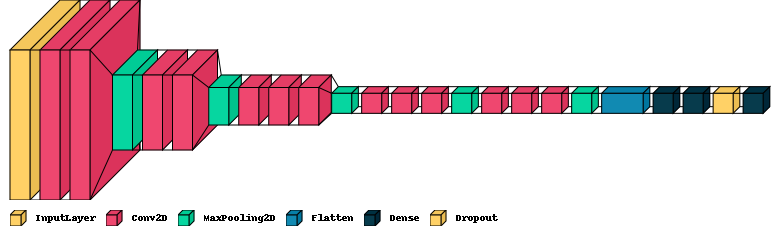

In [ ]:
import visualkeras
visualkeras.layered_view(review_model_1, legend = True, draw_volume = True, scale_xy = 0.5, scale_z = 0.001)

### 5. Model Training

In [ ]:
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

In [ ]:
%%time

vgg_history = vgg_model.fit(training_set,
                            batch_size=batch_size,
                            epochs=n_epochs,
                            validation_data=valid_set,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [ ]:
training_set.reset()
valid_set.reset()
testing_set.reset()

vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)

In [ ]:
%%time

vgg_ft_history = vgg_model_ft.fit(training_set,
                                  batch_size=batch_size,
                                  epochs=n_epochs,
                                  validation_data=valid_set,
                                  steps_per_epoch=n_steps,
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_2, early_stop, plot_loss_2],
                                  verbose=1)

### 6. Classification Report

In [ ]:
from sklearn.preprocessing import label_binarize
pred1 = vgg_model.predict(testing_set)
labels = label_binarize(testing_set.classes, classes = [0,1,2])
pd.DataFrame(classification_report(labels, pred1 > 0.5, output_dict=True))

In [ ]:
pred2 = vgg_model_ft.predict(testing_set)
pd.DataFrame(classification_report(labels, pred2 > 0.5, output_dict=True))